In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [8]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math as mt
import warnings

# 한글출력
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore') 

from src import crs
from src import get_col_list

SyntaxError: invalid syntax (3453904997.py, line 14)

In [3]:
# 1. load_excel
data_path = "data/apt_1.xlsx"
xlsx = pd.read_excel(data_path, header=None,
                     skiprows=2, engine="openpyxl")

# 2. data preprocessing
p, m = crs.utils.data_preprocessing(xlsx)

m.set_index("month", inplace=True)

# 3. data init
_month = 1

month_df = pd.DataFrame(m.loc[_month])
month_df.reset_index(inplace=True)

month_df.columns = ['name', 'usage (kWh)']

PUBLIC_PERCENTAGE = 30
APT = crs.utils.get_APT(month_df, PUBLIC_PERCENTAGE)

calc = crs.models.ManagementOffice(
        month=_month,
        households=month_df,
        APT=APT,
        contract="단일계약"
    )
apt = calc.apart

In [4]:
crs.utils.print_apt_info(_month, month_df, APT)

hh, anal = crs.utils.get_analysis_df(_month,month_df, APT)
anal = anal[anal.columns[:-1]]
anal['최종청구금액'] = anal.sum(axis=1).astype('int')
anal.head()

APT : 44,434kWh (평균 사용량: 411kWh)
		6,439,540원
세대부 : 31,104kWh (70%) (평균 사용량: 288kWh)
		3,798,980원
공용부 : 13,330kWh (30%) (평균 사용량: 123kWh)
		2,640,560원


,기본요금,전력량요금,기후환경요금,연료비 조정액,VAT,전력산업기반기금,최종청구금액
APT,654480,4907088,235224,-133164,566363,209550,6439541
세대부,197480,3118820,164805,-93312,334205,123150,3845148
공용부,457000,1788268,70419,-39852,232158,86400,2594393
세대부 / APT percentage,30,64,70,70,59,59,352
공용부 / APT percentage,70,36,30,30,41,41,248


# 데이터 소개
- 해당 데이터는 108가구의 1년치 월 별 사용량 데이터를 가지고 있는 데이터이다.
- 이 중, 1월달 데이터를 이용하여 공용부의 전기요금 구성요소들의 특징을 살펴보도록 한다.

In [5]:
m[m.columns[:10]]

,아파트1-101-1002,아파트1-101-104,아파트1-101-1102,아파트1-101-1202,아파트1-101-1302,아파트1-101-1401,아파트1-101-1403,아파트1-101-1502,아파트1-101-1504,아파트1-101-1602
month,,,,,,,,,,
1,253,689,183,239,455,343,380,219,389,350
2,251,481,177,218,397,297,339,197,348,288
3,255,424,203,222,378,303,349,202,357,368
4,252,355,180,230,368,278,298,188,346,365
5,230,357,258,203,414,270,418,156,320,265
6,212,363,272,207,411,275,398,149,265,254
7,326,423,416,204,597,350,477,210,374,441
8,431,454,450,207,701,411,505,236,385,533
9,207,334,198,188,445,299,369,153,261,258


# 기본요금

## 10%에서부터 40%까지 늘려가면서 진행한 공용부 기본요금의 변화

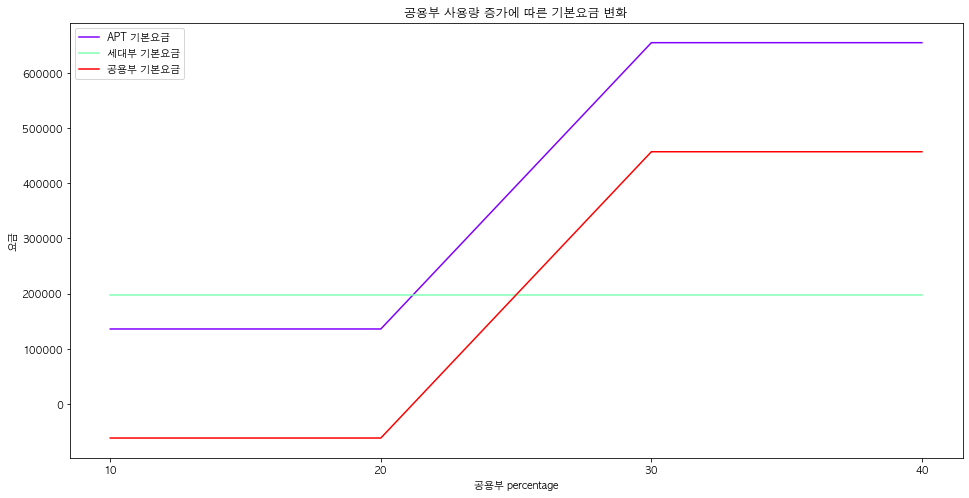

,10%,20%,30%,40%
APT,136080,136080,654480,654480
세대부,197480,197480,197480,197480
공용부,-61400,-61400,457000,457000


In [6]:
basic_df = pd.DataFrame(index=['APT', '세대부', '공용부'])

for PUBLIC_PERCENTAGE in range(10, 50, 10):
    APT = crs.utils.get_APT(month_df, PUBLIC_PERCENTAGE)
    _, anal_df = crs.utils.get_analysis_df(_month, month_df, APT)
    
    basic_df["{}%".format(PUBLIC_PERCENTAGE)] = \
        anal_df['기본요금'].values[:3]
    
plt.figure(figsize=(16,8))
palette = plt.cm.get_cmap("rainbow", len(basic_df))
for idx,(index_name, row) in enumerate(basic_df.iterrows()):
    plt.plot(range(10,50,10),row.values, c=palette(idx), 
             label="{} 기본요금".format(index_name))

plt.xticks(range(10,50,10))
plt.title("공용부 사용량 증가에 따른 기본요금 변화")
plt.ylabel("요금")
plt.xlabel("공용부 percentage")
plt.legend(loc='upper left')
plt.show()

basic_df[basic_df.columns[:5]]

## 공용부의 평균사용량을 1kWh씩 증가시키면서 변화를 확인

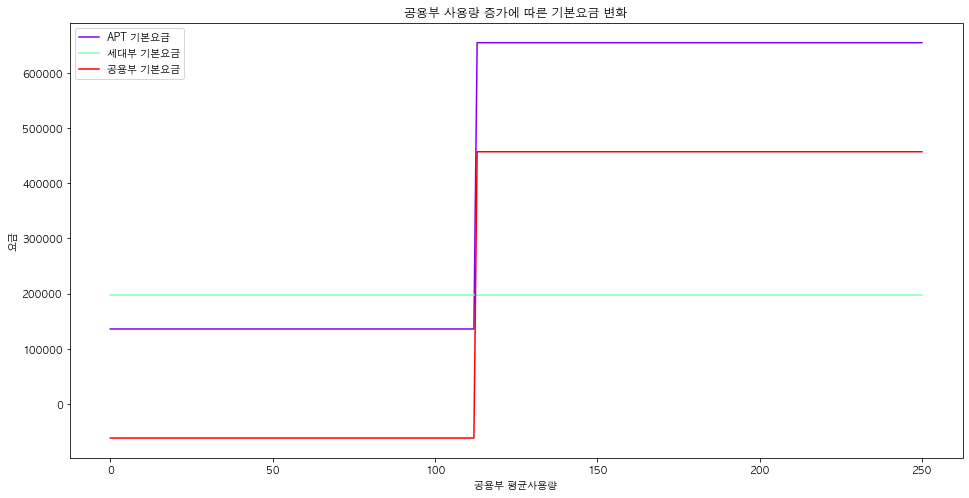

,0.0kWh,1.0kWh,2.0kWh,3.0kWh,4.0kWh
APT,136080,136080,136080,136080,136080
세대부,197480,197480,197480,197480,197480
공용부,-61400,-61400,-61400,-61400,-61400


In [7]:
basic_df = pd.DataFrame(index=['APT', '세대부', '공용부'])

for public_kWh in range(0, 27108, 108):
    APT = month_df['usage (kWh)'].sum() + public_kWh
    _, anal_df = crs.utils.get_analysis_df(_month, month_df, APT)
    
    basic_df["{}kWh".format(round(public_kWh) / 108)] = \
        anal_df['기본요금'].values[:3]
    
plt.figure(figsize=(16,8))
palette = plt.cm.get_cmap("rainbow", len(basic_df))
for idx,(index_name, row) in enumerate(basic_df.iterrows()):
    plt.plot(range(0, 251),row.values, c=palette(idx), 
             label="{} 기본요금".format(index_name))

plt.title("공용부 사용량 증가에 따른 기본요금 변화")
plt.ylabel("요금")
plt.xlabel("공용부 평균사용량")
plt.legend(loc='upper left')
plt.show()

basic_df[basic_df.columns[:5]]

## 세대부 사용량 구성에 따라 달라지는 공용부의 기본요금

In [8]:
step_df = month_df.copy()
step_df['누진단계'] = np.array([crs.utils.get_nugin_step(_, calc.fee) 
                   for _ in month_df['usage (kWh)']]) + 1

step_count = pd.DataFrame(
    step_df['누진단계'].groupby(step_df['누진단계']).count())
step_count.columns = ['가구 수']
step_count['기본요금'] = [_[2] for _ in calc.fee]
step_count['토탈'] = \
    step_count.apply(lambda x: x['가구 수'] * x['기본요금'], axis=1)

step_count.loc['세대부 토탈'] = step_count.sum(axis=0)

step_count

,가구 수,기본요금,토탈
누진단계,,,
1,20,730,14600
2,73,1260,91980
3,15,6060,90900
세대부 토탈,108,8050,197480


# 2. 전력량요금
---
- 공용부의 전력량요금은 APT 평균사용량 안에서 세대부 평균사용량 이후의 누진단계부터 가격 산정이 시작된다.

## 10%에서부터 40%까지 늘려가면서 진행한 공용부 기본요금의 변화

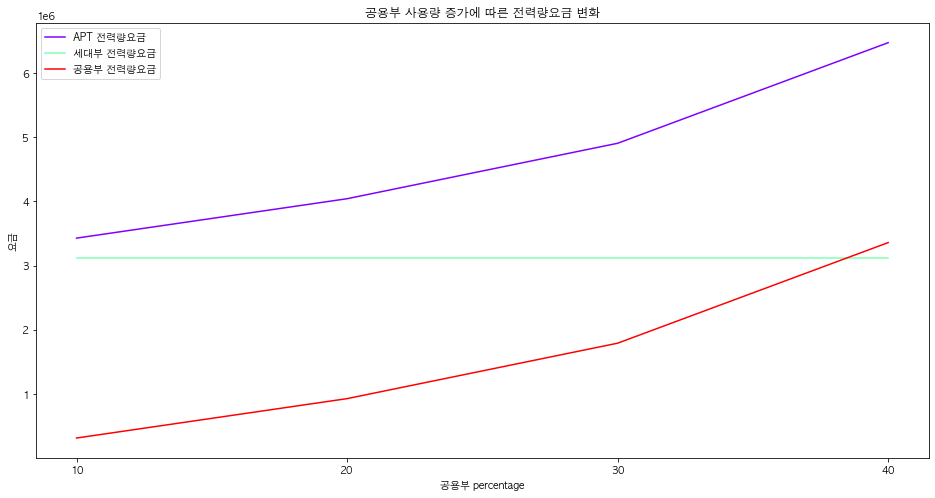

,10%,20%,30%,40%
APT,3427488,4042224,4907088,6476544
세대부,3118820,3118820,3118820,3118820
공용부,308668,923404,1788268,3357724


In [9]:
basic_df = pd.DataFrame(index=['APT', '세대부', '공용부'])

for PUBLIC_PERCENTAGE in range(10, 50, 10):
    APT = crs.utils.get_APT(month_df, PUBLIC_PERCENTAGE)
    _, anal_df = crs.utils.get_analysis_df(_month, month_df, APT)
    
    basic_df["{}%".format(PUBLIC_PERCENTAGE)] = \
        anal_df['전력량요금'].values[:3]
    
plt.figure(figsize=(16,8))
palette = plt.cm.get_cmap("rainbow", len(basic_df))
for idx,(index_name, row) in enumerate(basic_df.iterrows()):
    plt.plot(range(10,50,10),row.values, c=palette(idx), 
             label="{} 전력량요금".format(index_name))

plt.xticks(range(10,50,10))
plt.title("공용부 사용량 증가에 따른 전력량요금 변화")
plt.ylabel("요금")
plt.xlabel("공용부 percentage")
plt.legend(loc='upper left')
plt.show()

basic_df[basic_df.columns[:5]]

## 공용부의 평균사용량을 1kWh씩 증가시키면서 변화를 확인

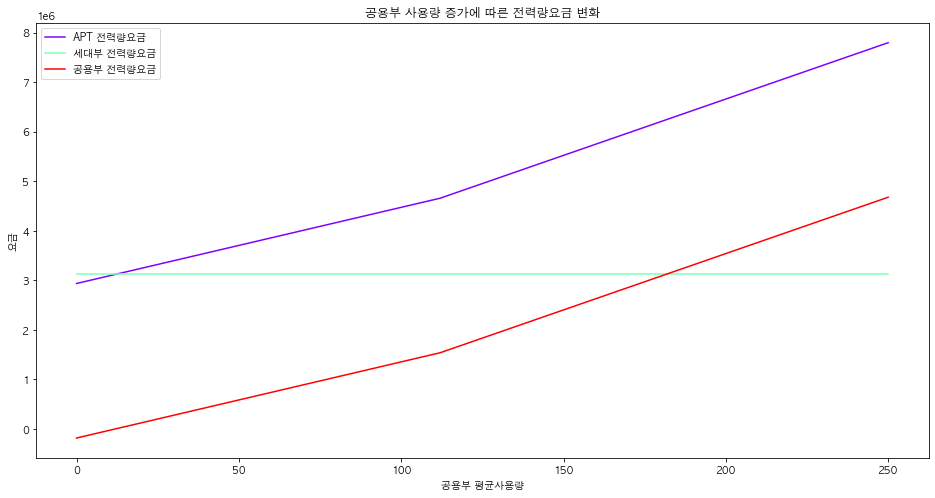

,0.0kWh,1.0kWh,2.0kWh,3.0kWh,4.0kWh
APT,2935656,2950992,2966436,2981772,2997108
세대부,3118820,3118820,3118820,3118820,3118820
공용부,-183164,-167828,-152384,-137048,-121712


In [10]:
basic_df = pd.DataFrame(index=['APT', '세대부', '공용부'])

for public_kWh in range(0, 27108, 108):
    APT = month_df['usage (kWh)'].sum() + public_kWh
    _, anal_df = crs.utils.get_analysis_df(_month, month_df, APT)
    
    basic_df["{}kWh".format(round(public_kWh) / 108)] = \
        anal_df['전력량요금'].values[:3]
    
plt.figure(figsize=(16,8))
palette = plt.cm.get_cmap("rainbow", len(basic_df))
for idx,(index_name, row) in enumerate(basic_df.iterrows()):
    plt.plot(range(0, 251),row.values, c=palette(idx), 
             label="{} 전력량요금".format(index_name))

plt.title("공용부 사용량 증가에 따른 전력량요금 변화")
plt.ylabel("요금")
plt.xlabel("공용부 평균사용량")
plt.legend(loc='upper left')
plt.show()

basic_df[basic_df.columns[:5]]

In [11]:
basic_df[basic_df.columns[200:]]

,200.0kWh,201.0kWh,202.0kWh,203.0kWh,204.0kWh,205.0kWh,206.0kWh,207.0kWh,208.0kWh,209.0kWh,...,241.0kWh,242.0kWh,243.0kWh,244.0kWh,245.0kWh,246.0kWh,247.0kWh,248.0kWh,249.0kWh,250.0kWh
APT,6658416,6681204,6703992,6726672,6749460,6772140,6794928,6817716,6840396,6863184,...,7590996,7613784,7636464,7659252,7681932,7704720,7727508,7750188,7772976,7795656
세대부,3118820,3118820,3118820,3118820,3118820,3118820,3118820,3118820,3118820,3118820,...,3118820,3118820,3118820,3118820,3118820,3118820,3118820,3118820,3118820,3118820
공용부,3539596,3562384,3585172,3607852,3630640,3653320,3676108,3698896,3721576,3744364,...,4472176,4494964,4517644,4540432,4563112,4585900,4608688,4631368,4654156,4676836


## 공용부가 0kWh일 때의 전력량요금의 가격 eq.공용부 전력량요금 시작요금

In [12]:
public_kWh = 0
APT = round((month_df['usage (kWh)'].sum() + public_kWh) / len(month_df))

### 전력량요금 수거현황판

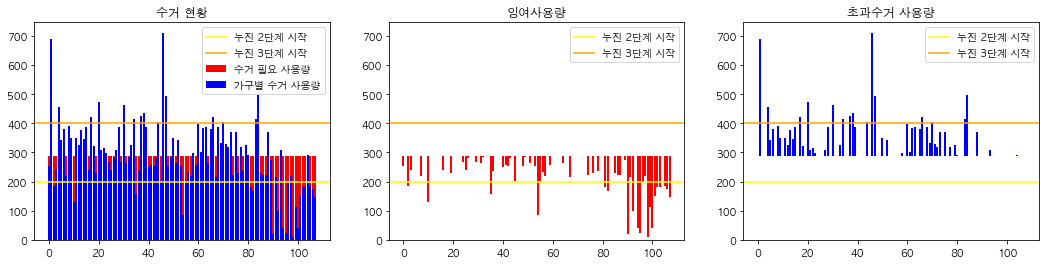

In [13]:
plt.figure(figsize=(18,4))

# 수거현황
ax_1 = plt.subplot(1,3,1)

ax_1.bar(range(0, len(month_df)), APT, color='r')
ax_1.bar(range(0, len(month_df)), month_df['usage (kWh)'], color='b')

ax_1.axhline(200, color='yellow')
ax_1.axhline(400, color='orange')

ax_1.set_title("수거 현황")
ax_1.legend(["누진 2단계 시작","누진 3단계 시작",'수거 필요 사용량', '가구별 수거 사용량'], loc='upper right')

# 잉여사용량
ax_2 = plt.subplot(1,3,2)

ax_2.bar(range(0, len(month_df)), APT, color='r')
ax_2.bar(range(0, len(month_df)), month_df['usage (kWh)'], color='white')

ax_2.axhline(200, color='yellow')
ax_2.axhline(400, color='orange')
ax_2.legend(["누진 2단계 시작","누진 3단계 시작"], loc='upper right')

ax_2.set_title("잉여사용량")

# 초과수거 사용량
ax_3 = plt.subplot(1,3,3)

ax_3.bar(range(0, len(month_df)), month_df['usage (kWh)'], color='b')
ax_3.bar(range(0, len(month_df)), APT, color='white')

ax_3.axhline(200, color='yellow')
ax_3.axhline(400, color='orange')
ax_3.legend(["누진 2단계 시작","누진 3단계 시작"], loc='upper right')

ax_3.set_title("초과수거 사용량")

plt.show()

### 전력량요금 수거현황 Table

In [14]:
all_col_needed = np.array(get_col_list(APT, calc.fee)) * len(month_df)
col_households = np.array([get_col_list(usage, calc.fee) for usage in month_df['usage (kWh)']]).sum(axis=0)

col_needed = np.array(get_col_list(APT, calc.fee))
surplus_col = np.zeros(3)
excess_col = np.zeros(3)

for usage in month_df['usage (kWh)']:
    col_chk = col_needed - get_col_list(usage, calc.fee)
    
    for idx, chk in enumerate(col_chk):
        if chk > 0:
            surplus_col[idx] += chk
        else:
            excess_col[idx] += abs(chk)
            
pd.DataFrame(np.array([all_col_needed, col_households,
         surplus_col, excess_col]).reshape(-1, 3).astype("int"), columns=['누진 1단계', '누진 2단계', '누진 3단계'],
            index=['수거 필요 사용량',' 수거 사용량', '잉여 사용량', '초과수거 사용량'])

,누진 1단계,누진 2단계,누진 3단계
수거 필요 사용량,21600,9504,0
수거 사용량,20061,9916,1127
잉여 사용량,1539,3358,0
초과수거 사용량,0,3770,1127


## 공용부가 112kWh일 때의 전력량요금의 가격 eq.공용부 전력량요금 시작요금

In [15]:
public_kWh = 112 * len(month_df)
APT = round((month_df['usage (kWh)'].sum() + public_kWh) / len(month_df))

### 전력량요금 수거현황판

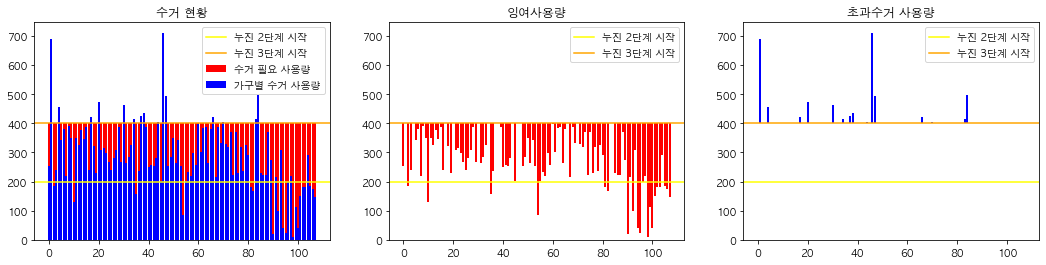

In [16]:
plt.figure(figsize=(18,4))

# 수거현황
ax_1 = plt.subplot(1,3,1)

ax_1.bar(range(0, len(month_df)), APT, color='r')
ax_1.bar(range(0, len(month_df)), month_df['usage (kWh)'], color='b')

ax_1.axhline(200, color='yellow')
ax_1.axhline(400, color='orange')

ax_1.set_title("수거 현황")
ax_1.legend(["누진 2단계 시작","누진 3단계 시작",'수거 필요 사용량', '가구별 수거 사용량'], loc='upper right')

# 잉여사용량
ax_2 = plt.subplot(1,3,2)

ax_2.bar(range(0, len(month_df)), APT, color='r')
ax_2.bar(range(0, len(month_df)), month_df['usage (kWh)'], color='white')

ax_2.axhline(200, color='yellow')
ax_2.axhline(400, color='orange')
ax_2.legend(["누진 2단계 시작","누진 3단계 시작"], loc='upper right')

ax_2.set_title("잉여사용량")

# 초과수거 사용량
ax_3 = plt.subplot(1,3,3)

ax_3.bar(range(0, len(month_df)), month_df['usage (kWh)'], color='b')
ax_3.bar(range(0, len(month_df)), APT, color='white')

ax_3.axhline(200, color='yellow')
ax_3.axhline(400, color='orange')
ax_3.legend(["누진 2단계 시작","누진 3단계 시작"], loc='upper right')

ax_3.set_title("초과수거 사용량")

plt.show()

In [17]:
all_col_needed = np.array(get_col_list(APT, calc.fee)) * len(month_df)
col_households = np.array([get_col_list(usage, calc.fee) for usage in month_df['usage (kWh)']]).sum(axis=0)

col_needed = np.array(get_col_list(APT, calc.fee))
surplus_col = np.zeros(3)
excess_col = np.zeros(3)

for usage in month_df['usage (kWh)']:
    col_chk = col_needed - get_col_list(usage, calc.fee)
    
    for idx, chk in enumerate(col_chk):
        if chk > 0:
            surplus_col[idx] += chk
        else:
            excess_col[idx] += abs(chk)
            
pd.DataFrame(np.array([all_col_needed, col_households,
         surplus_col, excess_col]).reshape(-1, 3).astype("int"), columns=['누진 1단계', '누진 2단계', '누진 3단계'],
            index=['수거 필요 사용량',' 수거 사용량', '잉여 사용량', '초과수거 사용량'])

,누진 1단계,누진 2단계,누진 3단계
수거 필요 사용량,21600,21600,0
수거 사용량,20061,9916,1127
잉여 사용량,1539,11684,0
초과수거 사용량,0,0,1127


## 공용부가 200kWh일 때의 전력량요금의 가격 eq.공용부 전력량요금 시작요금

In [18]:
public_kWh = 200 * len(month_df)
APT = round((month_df['usage (kWh)'].sum() + public_kWh) / len(month_df))

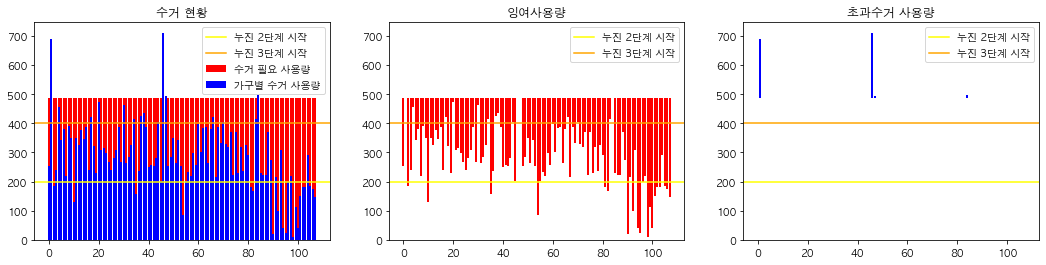

In [19]:
plt.figure(figsize=(18,4))

# 수거현황
ax_1 = plt.subplot(1,3,1)

ax_1.bar(range(0, len(month_df)), APT, color='r')
ax_1.bar(range(0, len(month_df)), month_df['usage (kWh)'], color='b')

ax_1.axhline(200, color='yellow')
ax_1.axhline(400, color='orange')

ax_1.set_title("수거 현황")
ax_1.legend(["누진 2단계 시작","누진 3단계 시작",'수거 필요 사용량', '가구별 수거 사용량'], loc='upper right')

# 잉여사용량
ax_2 = plt.subplot(1,3,2)

ax_2.bar(range(0, len(month_df)), APT, color='r')
ax_2.bar(range(0, len(month_df)), month_df['usage (kWh)'], color='white')

ax_2.axhline(200, color='yellow')
ax_2.axhline(400, color='orange')
ax_2.legend(["누진 2단계 시작","누진 3단계 시작"], loc='upper right')

ax_2.set_title("잉여사용량")

# 초과수거 사용량
ax_3 = plt.subplot(1,3,3)

ax_3.bar(range(0, len(month_df)), month_df['usage (kWh)'], color='b')
ax_3.bar(range(0, len(month_df)), APT, color='white')

ax_3.axhline(200, color='yellow')
ax_3.axhline(400, color='orange')
ax_3.legend(["누진 2단계 시작","누진 3단계 시작"], loc='upper right')

ax_3.set_title("초과수거 사용량")

plt.show()

In [20]:
all_col_needed = np.array(get_col_list(APT, calc.fee)) * len(month_df)
col_households = np.array([get_col_list(usage, calc.fee) for usage in month_df['usage (kWh)']]).sum(axis=0)

col_needed = np.array(get_col_list(APT, calc.fee))
surplus_col = np.zeros(3)
excess_col = np.zeros(3)

for usage in month_df['usage (kWh)']:
    col_chk = col_needed - get_col_list(usage, calc.fee)
    
    for idx, chk in enumerate(col_chk):
        if chk > 0:
            surplus_col[idx] += chk
        else:
            excess_col[idx] += abs(chk)
            
pd.DataFrame(np.array([all_col_needed, col_households,
         surplus_col, excess_col]).reshape(-1, 3).astype("int"), columns=['누진 1단계', '누진 2단계', '누진 3단계'],
            index=['수거 필요 사용량',' 수거 사용량', '잉여 사용량', '초과수거 사용량'])

,누진 1단계,누진 2단계,누진 3단계
수거 필요 사용량,21600,21600,9504
수거 사용량,20061,9916,1127
잉여 사용량,1539,11684,8817
초과수거 사용량,0,0,440


## 공용부 전력량요금의 증가율 eq.공용부 1kWh증가의 의미

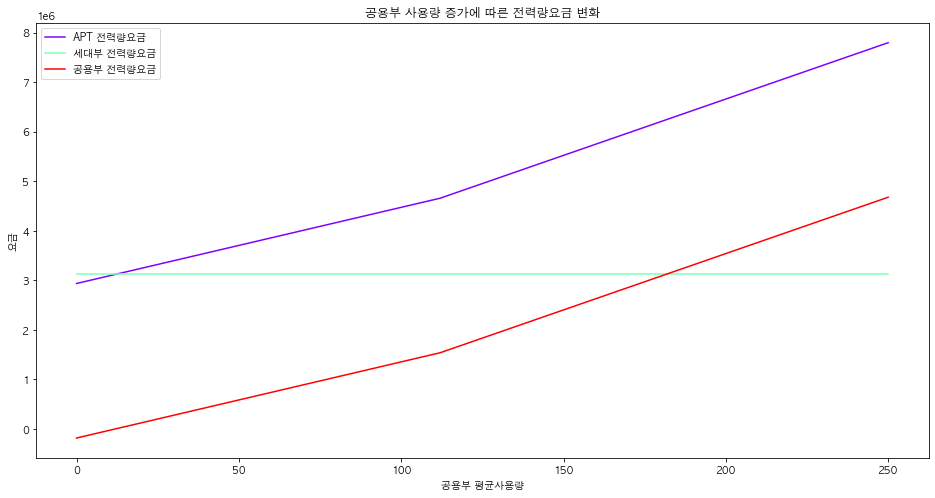

,0.0kWh,1.0kWh,2.0kWh,3.0kWh,4.0kWh
APT,2935656,2950992,2966436,2981772,2997108
세대부,3118820,3118820,3118820,3118820,3118820
공용부,-183164,-167828,-152384,-137048,-121712


In [21]:
basic_df = pd.DataFrame(index=['APT', '세대부', '공용부'])

for public_kWh in range(0, 27108, 108):
    APT = month_df['usage (kWh)'].sum() + public_kWh
    _, anal_df = crs.utils.get_analysis_df(_month, month_df, APT)
    
    basic_df["{}kWh".format(round(public_kWh) / 108)] = \
        anal_df['전력량요금'].values[:3]
    
plt.figure(figsize=(16,8))
palette = plt.cm.get_cmap("rainbow", len(basic_df))
for idx,(index_name, row) in enumerate(basic_df.iterrows()):
    plt.plot(range(0, 251),row.values, c=palette(idx), 
             label="{} 전력량요금".format(index_name))

plt.title("공용부 사용량 증가에 따른 전력량요금 변화")
plt.ylabel("요금")
plt.xlabel("공용부 평균사용량")
plt.legend(loc='upper left')
plt.show()

basic_df[basic_df.columns[:5]]

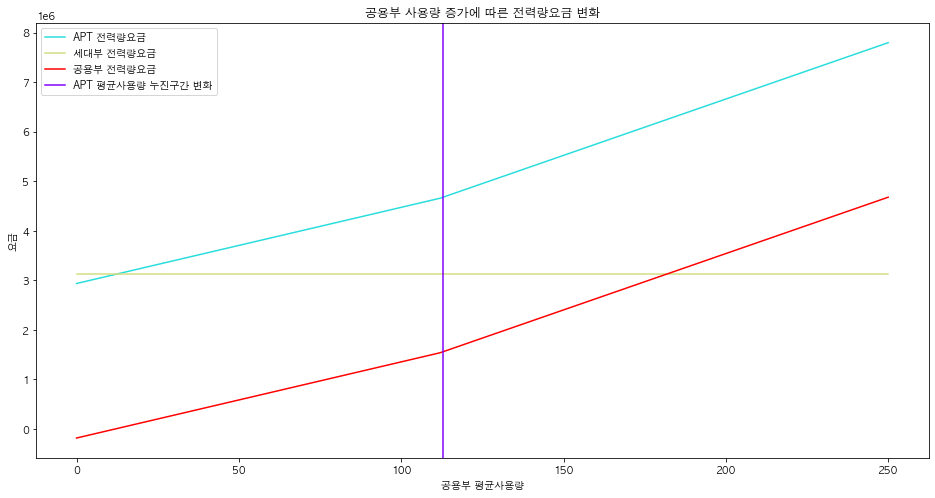

In [22]:
plt.figure(figsize=(16,8))
palette = plt.cm.get_cmap("rainbow", len(basic_df) + 1)
for idx,(index_name, row) in enumerate(basic_df.iterrows()):
    plt.plot(range(0, 251),row.values, c=palette(idx + 1), 
             label="{} 전력량요금".format(index_name))

plt.title("공용부 사용량 증가에 따른 전력량요금 변화")
plt.ylabel("요금")
plt.xlabel("공용부 평균사용량")
plt.axvline(401 - month_df['usage (kWh)'].mean(), c=palette(0), label="APT 평균사용량 누진구간 변화")

plt.legend(loc='upper left')
plt.show()

In [23]:
public_df = pd.DataFrame(basic_df.loc[['공용부']]).T
public_df.columns = ['현재 전력량요금']

public_df['다음 전력량요금'] = public_df['현재 전력량요금'].shift(-1).fillna(0)
public_df = public_df[:250].copy()

public_df['오차'] = (public_df['다음 전력량요금'] - public_df['현재 전력량요금']).abs()
public_df.head()

,현재 전력량요금,다음 전력량요금,오차
0.0kWh,-183164,-167828,15336
1.0kWh,-167828,-152384,15444
2.0kWh,-152384,-137048,15336
3.0kWh,-137048,-121712,15336
4.0kWh,-121712,-106376,15336


## 세대부 테스트

In [30]:
md = month_df.copy()
basic_mem = list()

for cnt in range(0, 101, 25):
    md['usage (kWh)'] = month_df['usage (kWh)'] + cnt
    basic_df = pd.DataFrame(index=['APT', '세대부', '공용부'])
    for public_kWh in range(0, 21601, 108):
        APT = md['usage (kWh)'].sum() + public_kWh
        _, anal_df = crs.utils.get_analysis_df(_month, month_df, APT)
        
        basic_df["{}kWh".format(round(public_kWh) / 108)] = \
        anal_df['전력량요금'].values[:3]
        
    basic_mem.append((md['usage (kWh)'].sum(),basic_df))

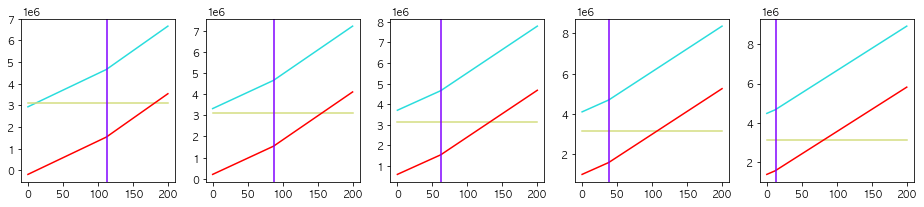

In [31]:
public_kWh = 21600
palette = plt.cm.get_cmap("rainbow", len(basic_mem[0][1]) + 1)

plt.figure(figsize=(16,3))
for idx, (h_kWh, basic_df) in enumerate(basic_mem):
    ax = plt.subplot(1, 5, idx + 1)
    for idx,(index_name, row) in enumerate(basic_df.iterrows()):
        ax.plot(range(0, 201),row.values, c=palette(idx + 1), 
                 label="{} 전력량요금".format(index_name))
    
    change = 401 - h_kWh / len(month_df)
    ax.axvline(change, c=palette(0))
    
plt.show()

# 3. 기후환경요금, 연료비 조정액

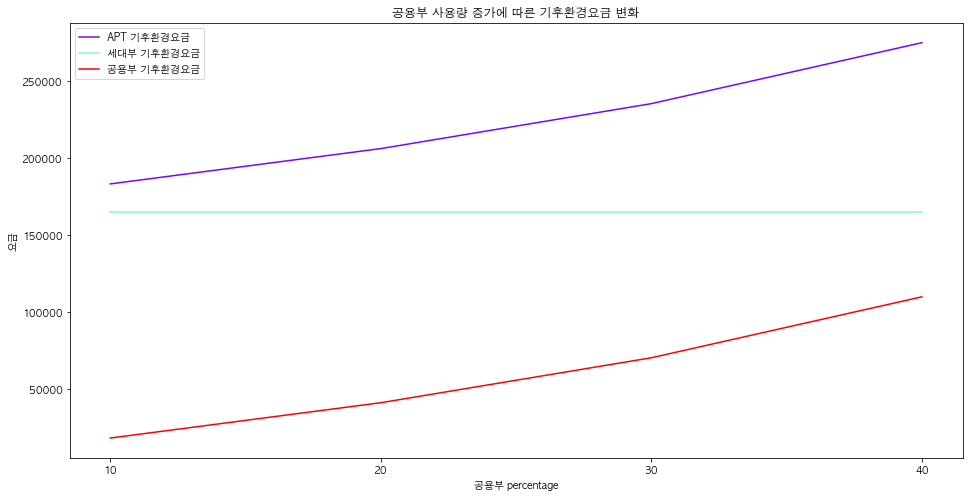

,10%,20%,30%,40%
APT,183168,206064,235224,274752
세대부,164805,164805,164805,164805
공용부,18363,41259,70419,109947


In [32]:
basic_df = pd.DataFrame(index=['APT', '세대부', '공용부'])

for PUBLIC_PERCENTAGE in range(10, 50, 10):
    APT = crs.utils.get_APT(month_df, PUBLIC_PERCENTAGE)
    _, anal_df = crs.utils.get_analysis_df(_month, month_df, APT)
    
    basic_df["{}%".format(PUBLIC_PERCENTAGE)] = \
        anal_df['기후환경요금'].values[:3]
    
plt.figure(figsize=(16,8))
palette = plt.cm.get_cmap("rainbow", len(basic_df))
for idx,(index_name, row) in enumerate(basic_df.iterrows()):
    plt.plot(range(10,50,10),row.values, c=palette(idx), 
             label="{} 기후환경요금".format(index_name))

plt.xticks(range(10,50,10))
plt.title("공용부 사용량 증가에 따른 기후환경요금 변화")
plt.ylabel("요금")
plt.xlabel("공용부 percentage")
plt.legend(loc='upper left')
plt.show()

basic_df[basic_df.columns[:5]]

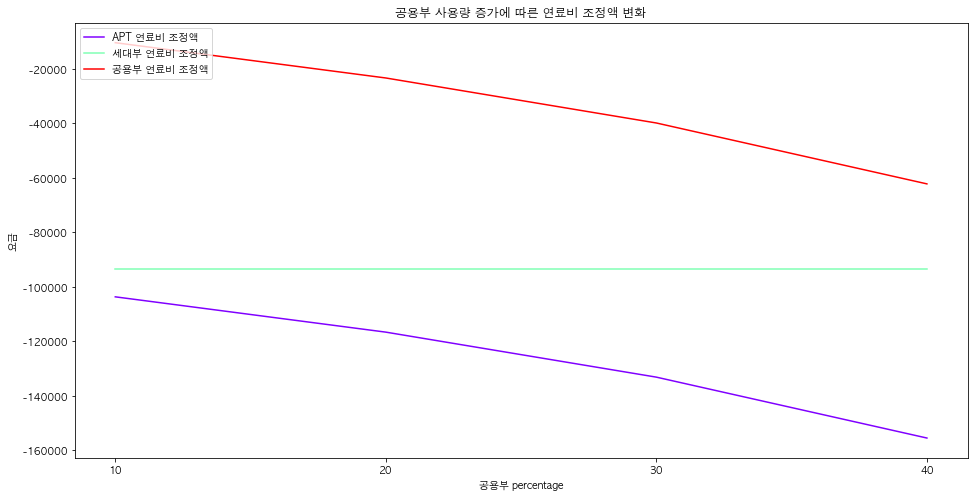

,10%,20%,30%,40%
APT,-103680,-116640,-133164,-155520
세대부,-93312,-93312,-93312,-93312
공용부,-10368,-23328,-39852,-62208


In [33]:
basic_df = pd.DataFrame(index=['APT', '세대부', '공용부'])

for PUBLIC_PERCENTAGE in range(10, 50, 10):
    APT = crs.utils.get_APT(month_df, PUBLIC_PERCENTAGE)
    _, anal_df = crs.utils.get_analysis_df(_month, month_df, APT)
    
    basic_df["{}%".format(PUBLIC_PERCENTAGE)] = \
        anal_df['연료비 조정액'].values[:3]
    
plt.figure(figsize=(16,8))
palette = plt.cm.get_cmap("rainbow", len(basic_df))
for idx,(index_name, row) in enumerate(basic_df.iterrows()):
    plt.plot(range(10,50,10),row.values, c=palette(idx), 
             label="{} 연료비 조정액".format(index_name))

plt.xticks(range(10,50,10))
plt.title("공용부 사용량 증가에 따른 연료비 조정액 변화")
plt.ylabel("요금")
plt.xlabel("공용부 percentage")
plt.legend(loc='upper left')
plt.show()

basic_df[basic_df.columns[:5]]